In [1]:
import os
import logging
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import patches as patches

from model import Net
from datasets import CubeObstacle, CylinderObstacle, SvlDataset
from utils.tools import calc_sig_strength_gpu, calc_loss

logging.basicConfig(level=logging.INFO)

random_seed = 42
torch.random.manual_seed(random_seed)
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
svl_model_path = "model/supervised/8500_model.pt"
usvl_model_path = "model/unsupervised/8500_model.pt"

In [2]:
obstacle_ls = [
    CubeObstacle(-30, 15, 35, 60, 20, 0.3),
    CubeObstacle(-30, -25, 45, 10, 35, 0.3),
    CylinderObstacle(0, -30, 70, 10, 0.3)
]
obst_points = []
for obstacle in obstacle_ls:
    obst_points.append(torch.tensor(obstacle.points, dtype=torch.float32))
obst_points = torch.cat([op for op in obst_points], dim=1).mT.to(device)

In [3]:
df = pd.concat([pd.read_csv('data/data1.csv'), pd.read_csv('data/data2.csv')])
# df = pd.read_csv('data/data.csv')
logging.info(df.shape)
x = df.iloc[:, :12].values
y = df.iloc[:, 12:].values

scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

x_scaled = scaler_x.fit_transform(x)
y_scaled = scaler_y.fit_transform(y)

x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.25, random_state=42)

logging.info(f"train shape: {x_train.shape}, val shape: {x_val.shape}")

val_dataset = SvlDataset(x_val, y_val, dtype=torch.float32).to(device)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

svl_model = Net(val_dataset.x.shape[1], 1024, 4).to(device)
usvl_model = Net(val_dataset.x.shape[1], 1024, 4, output_N=2).to(device)

INFO:root:(1048576, 15)
INFO:root:train shape: (786432, 12), val shape: (262144, 12)


/tmp/ipykernel_228591/3494603146.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svl_checkpoint = torch.load(svl_model_path)
/tmp/ipykernel_228591/3494603146.py:7: Futur

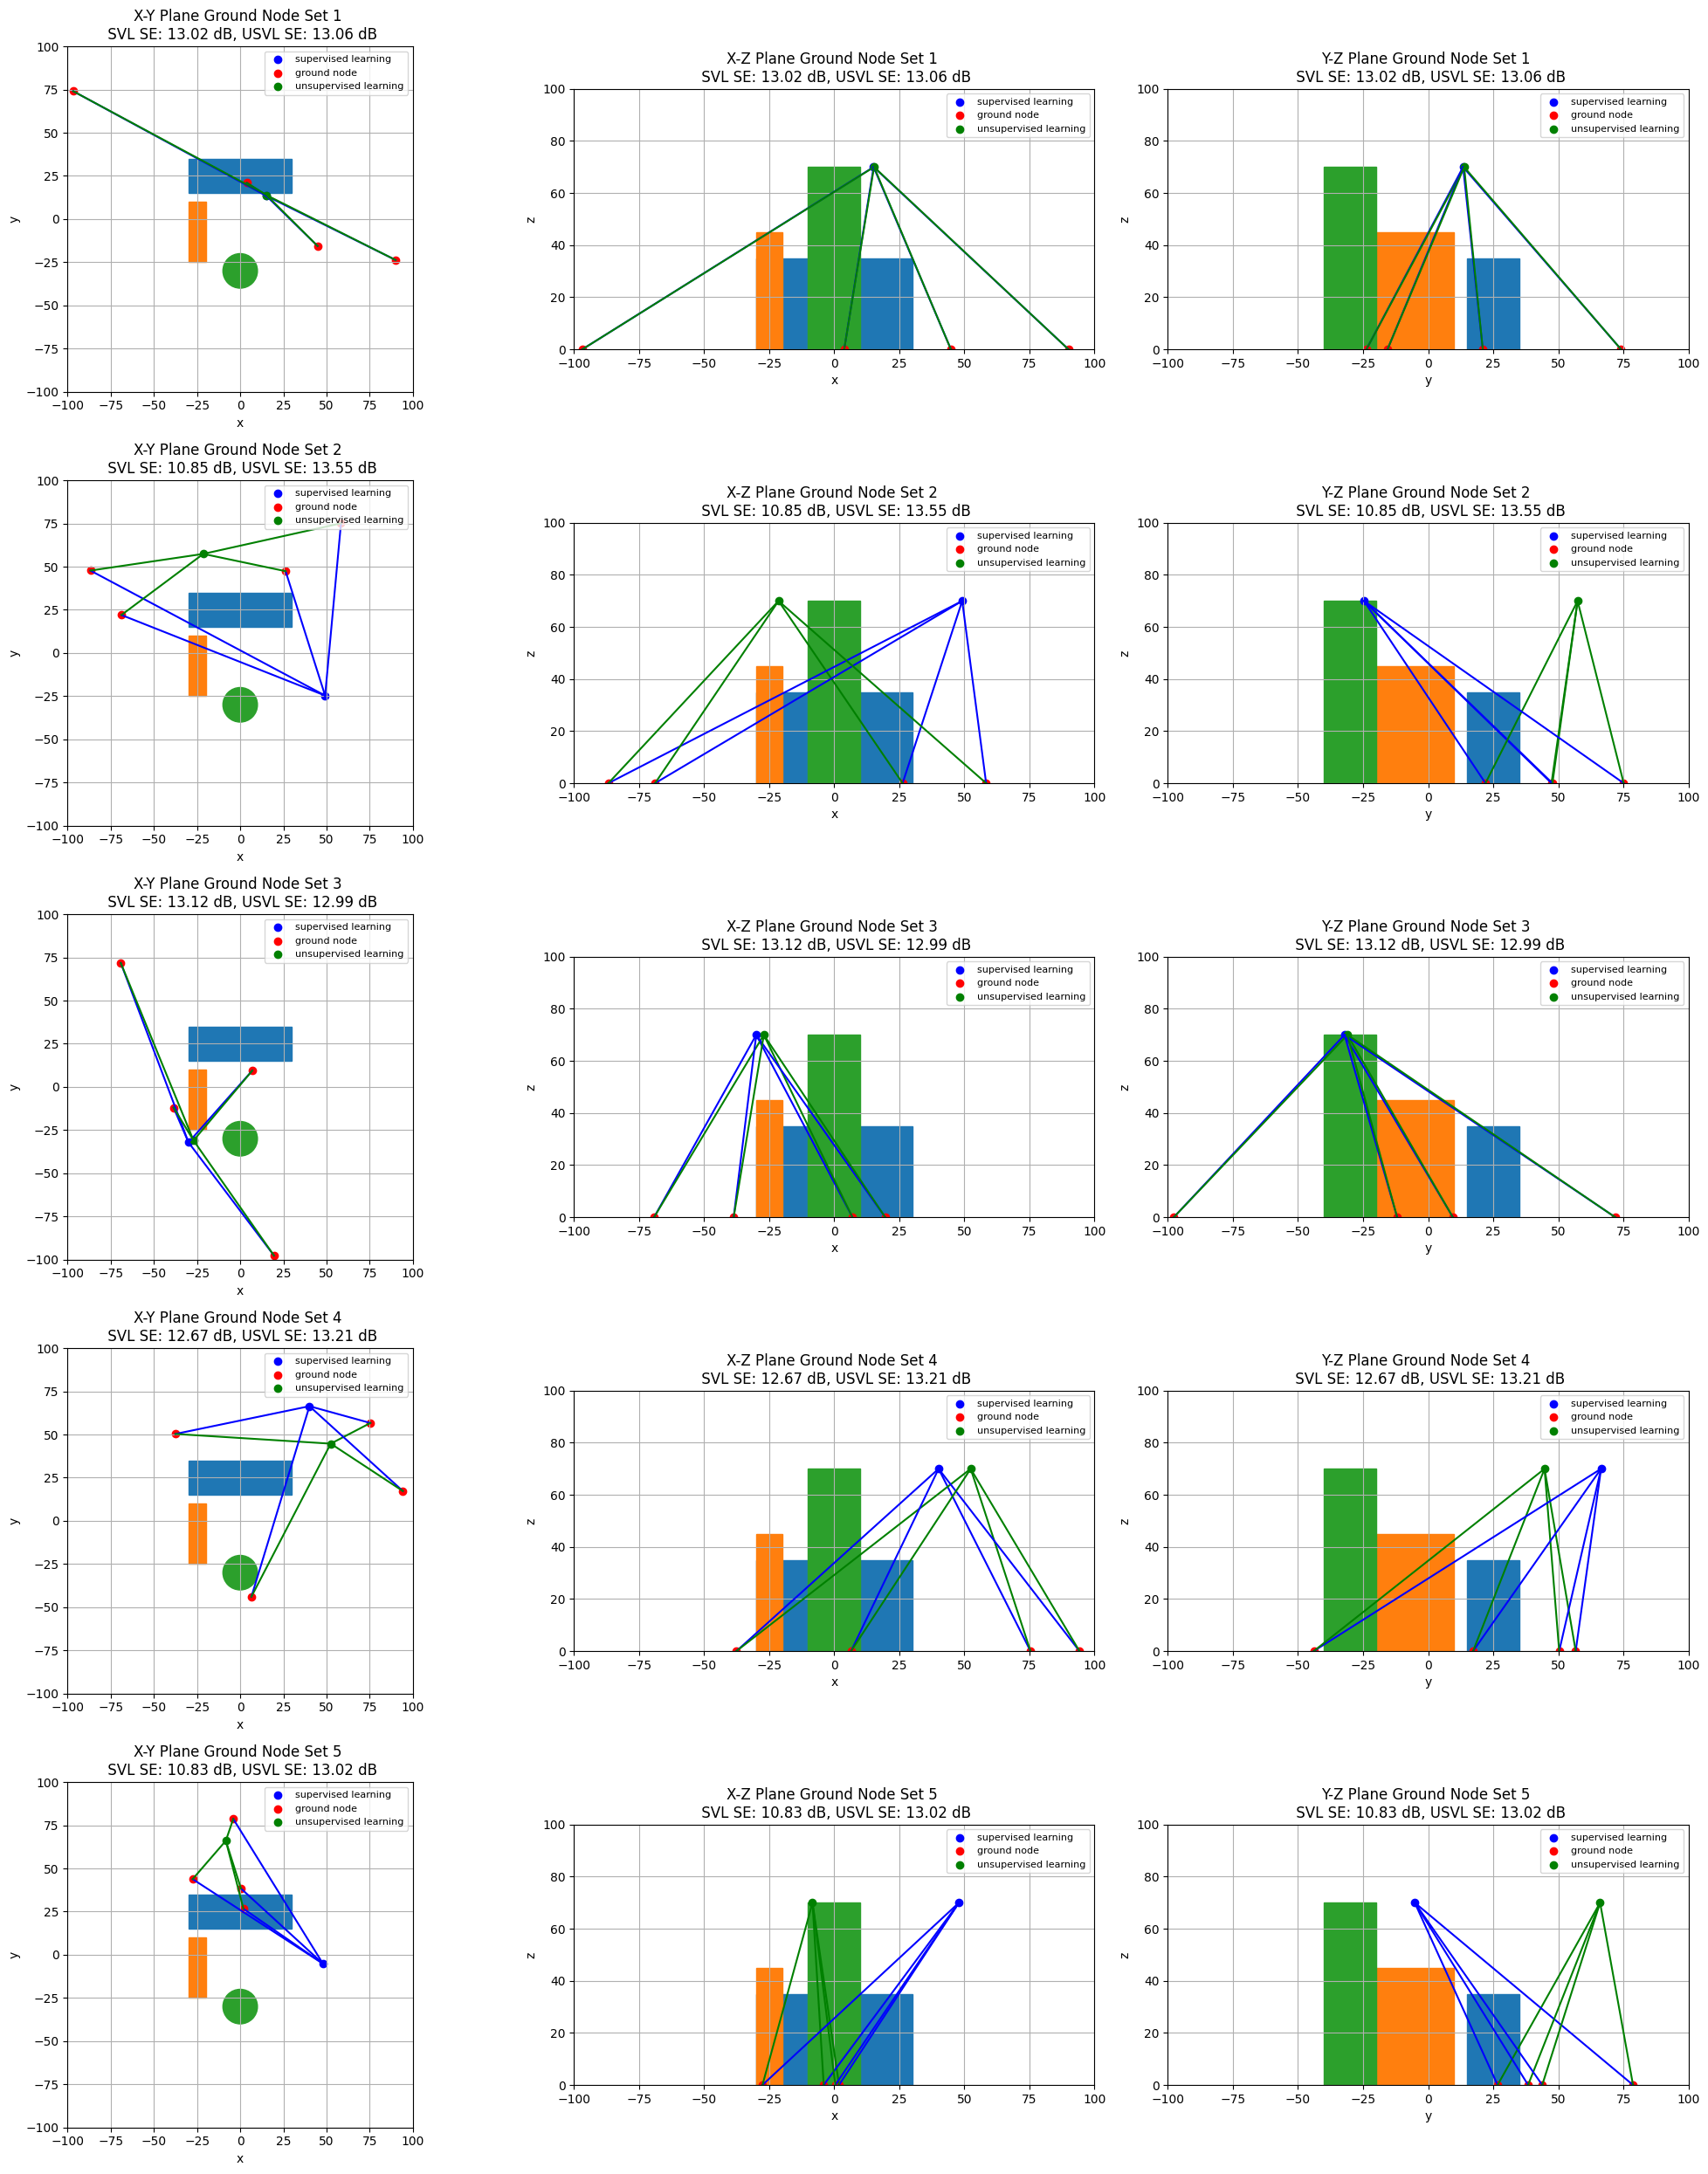

In [4]:
fig, ax = plt.subplots(5, 3, figsize=(20, 25), constrained_layout=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
with torch.no_grad():
    for i in range(5):
        svl_checkpoint = torch.load(svl_model_path)
        usvl_checkpoint = torch.load(usvl_model_path)
        svl_model.load_state_dict(svl_checkpoint['model_state_dict'])
        usvl_model.load_state_dict(usvl_checkpoint['model_state_dict'])
            
        svl_model.eval()
        x_val_batch = val_loader.dataset.x[i].unsqueeze(0)
        svl_pred = svl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        svl_pred = torch.from_numpy(scaler_y.inverse_transform(svl_pred.cpu().numpy())).to(device, dtype=torch.float32)
        
        usvl_model.eval()
        usvl_pred = usvl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        usvl_pred = torch.hstack((usvl_pred, torch.ones(usvl_pred.shape[0], 1).to(device) * 0.85)) * 200 - 100

        x_val_origin = scaler_x.inverse_transform(x_val_batch.cpu())
                
        val_gnd = torch.from_numpy(x_val_origin).to(device, dtype=torch.float32).view(4, 3)
        val_station = torch.tensor(y_val[0], dtype=torch.float32).unsqueeze(0).to(device)
        svl_station = svl_pred.clone().detach().to(device, dtype=torch.float32)
        usvl_station = usvl_pred.clone().detach().to(device, dtype=torch.float32)
                
        val_se = calc_sig_strength_gpu(val_station, val_gnd, obst_points).cpu().numpy()
        svl_pred_se = calc_sig_strength_gpu(svl_station,  val_gnd, obst_points).cpu().numpy()
        usvl_pred_se = calc_sig_strength_gpu(usvl_station,  val_gnd, obst_points).cpu().numpy()
            
        val_gnd = val_gnd.cpu().numpy()
        svl_station = svl_station.cpu().numpy()
        usvl_station = usvl_station.cpu().numpy()
            
        ax[i, 0].grid(True)
        ax[i, 0].set_xlim(-100, 100)
        ax[i, 0].set_ylim(-100, 100)
        ax[i, 0].set_aspect('equal')
        ax[i, 0].add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
        ax[i, 0].add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
        ax[i, 0].add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 1], svl_station[0, 1]], color='b'))
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 1], usvl_station[0, 1]], color='g'))
        ax[i, 0].scatter(svl_station[0, 0], svl_station[0, 1], c='b', label='supervised learning')
        ax[i, 0].scatter(val_gnd[:, 0], val_gnd[:, 1], c='r', label='ground node')
        ax[i, 0].scatter(usvl_station[0, 0], usvl_station[0, 1], c='g', label='unsupervised learning')
        ax[i, 0].set_title(f"X-Y Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 0].set_xlabel('x')
        ax[i, 0].set_ylabel('y')
            
        ax[i, 0].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 1].grid(True)
        ax[i, 1].set_xlim(-100, 100)
        ax[i, 1].set_ylim(0, 100)
        ax[i, 1].set_aspect('equal')
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 60, 35, fill=True, color=colors[0]))
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 10, 45, fill=True, color=colors[1]))
        ax[i, 1].add_patch(patches.Rectangle((-10, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 1].scatter(svl_station[0, 0], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 1].scatter(val_gnd[:, 0], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 1].scatter(usvl_station[0, 0], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 1].set_title(f"X-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 1].set_xlabel('x')
        ax[i, 1].set_ylabel('z')
        ax[i, 1].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 2].grid(True)
        ax[i, 2].set_xlim(-100, 100)
        ax[i, 2].set_ylim(0, 100)
        ax[i, 2].set_aspect('equal')
        ax[i, 2].add_patch(patches.Rectangle((15, 0), 20, 35, fill=True, color=colors[0]))
        ax[i, 2].add_patch(patches.Rectangle((-25, 0), 35, 45, fill=True, color=colors[1]))
        ax[i, 2].add_patch(patches.Rectangle((-40, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], svl_station[0, 1]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], usvl_station[0, 1]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 2].scatter(svl_station[0, 1], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 2].scatter(val_gnd[:, 1], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 2].scatter(usvl_station[0, 1], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 2].set_title(f"Y-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 2].set_xlabel('y')
        ax[i, 2].set_ylabel('z')
        ax[i, 2].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
    plt.savefig("results/results1.png", dpi=300)
    plt.show()    

<Figure size 3000x3000 with 0 Axes>

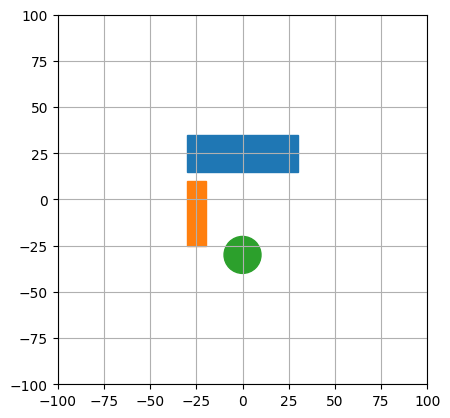

In [5]:
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal')

ax.add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
ax.add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
ax.add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
plt.savefig("results/obstacle.png", dpi=300)

plt.show()

<Figure size 3000x3000 with 0 Axes>

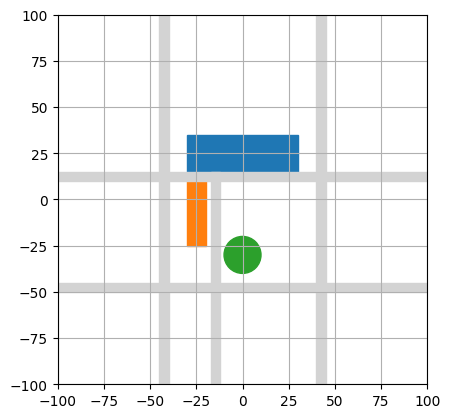

In [6]:
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal')

ax.add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
ax.add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
ax.add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
ax.add_patch(patches.Rectangle((-100, 10), 200, 5, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-45, -100), 5, 200, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((40, -100), 5, 200, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-100, -50), 200, 5, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-17, -100), 5, 115, fill=True, color='lightgray'))

In [7]:
def is_onRoad(x, y):
    if 10 < y < 15:
        return True
    elif -50 < y < -45:
        return True
    elif -45 < x < -40:
        return True
    elif -17 < x < -12 and y < 15:
        return True
    elif 40 < x < 45:
        return True
    
    else: return False

(71.97089806702434, -49.637059598173664, 0)
(-15.510841993824172, -20.382564352753832, 0)
(-40.26556852249006, 73.38820856610246, 0)
(-12.593254910045843, -20.622121382192077, 0)
0
(-15.312239020041503, 2.9855017721344126, 0)
(70.50774817119341, -48.41209864261988, 0)
(43.13253041446228, 57.631957627141276, 0)
(40.82087215432736, 17.945807215293158, 0)
1
(-70.02744022268968, 14.36575423653818, 0)
(-17.214788389482223, -45.988306779688855, 0)
(-16.756593793537107, -64.0681421940176, 0)
(37.82181629736482, 13.01445660733873, 0)
2
(80.29717022014981, -45.923352937868735, 0)
(-43.612623131648306, -11.280059736362574, 0)
(40.98222654626721, -82.95990448806761, 0)
(-42.413181181356194, -62.89480494845616, 0)
3
(-15.122196385497915, -68.64741048014108, 0)
(-14.718788701605433, 7.483387719961399, 0)
(-96.393598034954, 11.409517238446824, 0)
(-87.69139317303262, -46.00527262890759, 0)
4


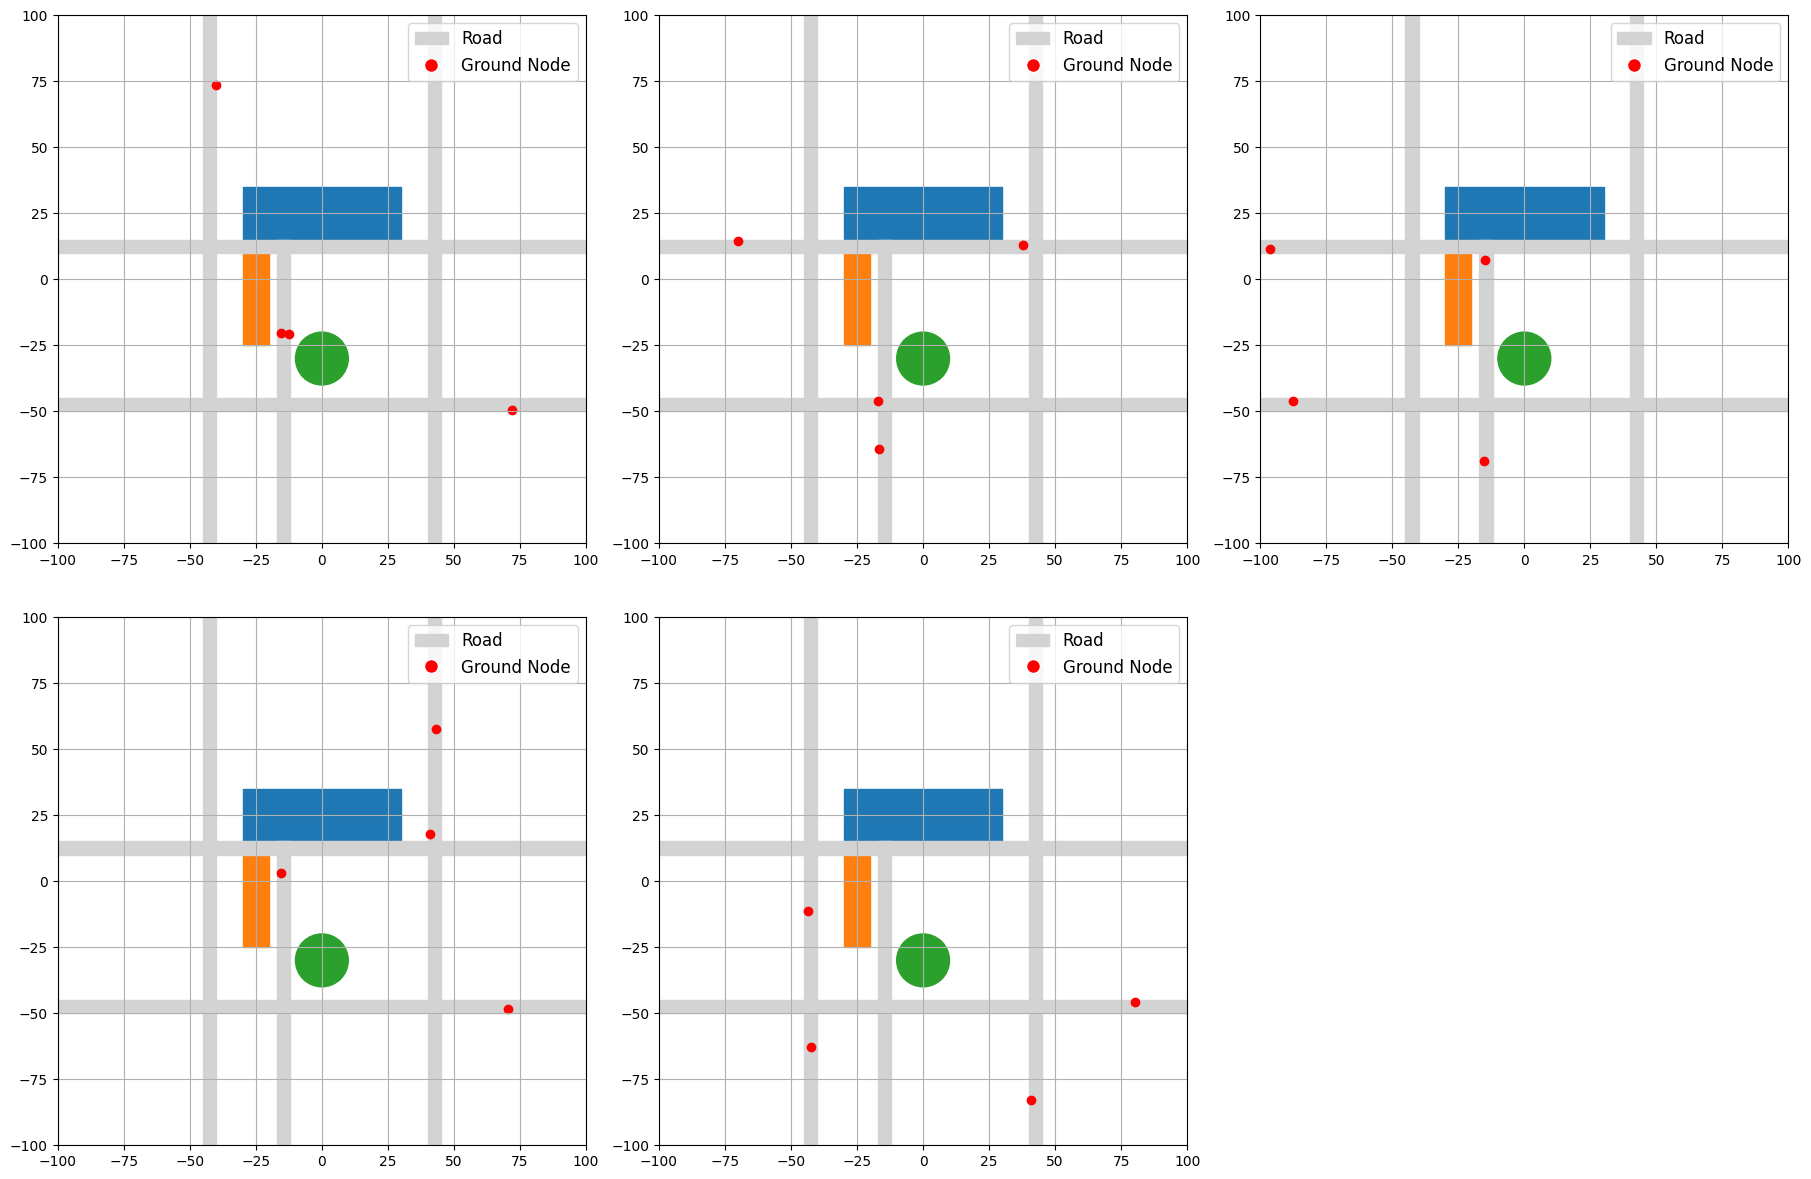

In [8]:
from matplotlib.patches import Patch

fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

gnd_nodes = np.zeros((5, 4, 3))
for i in range(5):
    row, col = i % 2, i // 2
    ax[row, col].grid(True)
    ax[row, col].set_xlim(-100, 100)
    ax[row, col].set_ylim(-100, 100)
    ax[row, col].set_aspect('equal')

    ax[row, col].add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
    ax[row, col].add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
    ax[row, col].add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
    ax[row, col].add_patch(patches.Rectangle((-100, 10), 200, 5, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-45, -100), 5, 200, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((40, -100), 5, 200, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-100, -50), 200, 5, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-17, -100), 5, 115, fill=True, color='lightgray'))
    gnd_node = []
    while len(gnd_node) < 4:
        x = np.random.rand() * 200 - 100
        y = np.random.rand() * 200 - 100
        z = 0
        if (x, y) not in gnd_node and is_onRoad(x, y):
            gnd_node.append((x, y, z))
            print((x, y, z))
            ax[row, col].scatter(x, y, c='r', label='Ground Node')
            
    lightgray_patch = Patch(color='lightgray', label='Road')
    scatter_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Ground Node')
    ax[row, col].legend(handles=[lightgray_patch, scatter_legend], loc='upper right', fontsize=12, ncol=1)

    gnd_nodes[i] = np.array(gnd_node)
    print(i)
fig.delaxes(ax[1, 2])

In [9]:
gnd_nodes.shape

(5, 4, 3)

In [10]:
gnd_nodes = gnd_nodes.reshape(-1, 12)
gnd_nodes

array([[ 71.97089807, -49.6370596 ,   0.        , -15.51084199,
        -20.38256435,   0.        , -40.26556852,  73.38820857,
          0.        , -12.59325491, -20.62212138,   0.        ],
       [-15.31223902,   2.98550177,   0.        ,  70.50774817,
        -48.41209864,   0.        ,  43.13253041,  57.63195763,
          0.        ,  40.82087215,  17.94580722,   0.        ],
       [-70.02744022,  14.36575424,   0.        , -17.21478839,
        -45.98830678,   0.        , -16.75659379, -64.06814219,
          0.        ,  37.8218163 ,  13.01445661,   0.        ],
       [ 80.29717022, -45.92335294,   0.        , -43.61262313,
        -11.28005974,   0.        ,  40.98222655, -82.95990449,
          0.        , -42.41318118, -62.89480495,   0.        ],
       [-15.12219639, -68.64741048,   0.        , -14.7187887 ,
          7.48338772,   0.        , -96.39359803,  11.40951724,
          0.        , -87.69139317, -46.00527263,   0.        ]])

In [11]:
x = df.iloc[:, :12].values
y = df.iloc[:, 12:].values

np.vstack([gnd_nodes, x])
new_scaler_x = MinMaxScaler(feature_range=(0, 1))
new_x_scaled = new_scaler_x.fit_transform(np.vstack([gnd_nodes, x]))
([new_x_scaled[5:]] == x_scaled[:]).all()

np.True_

/tmp/ipykernel_228591/685117922.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svl_checkpoint = torch.load(svl_model_path)
/tmp/ipykernel_228591/685117922.py:8: FutureW

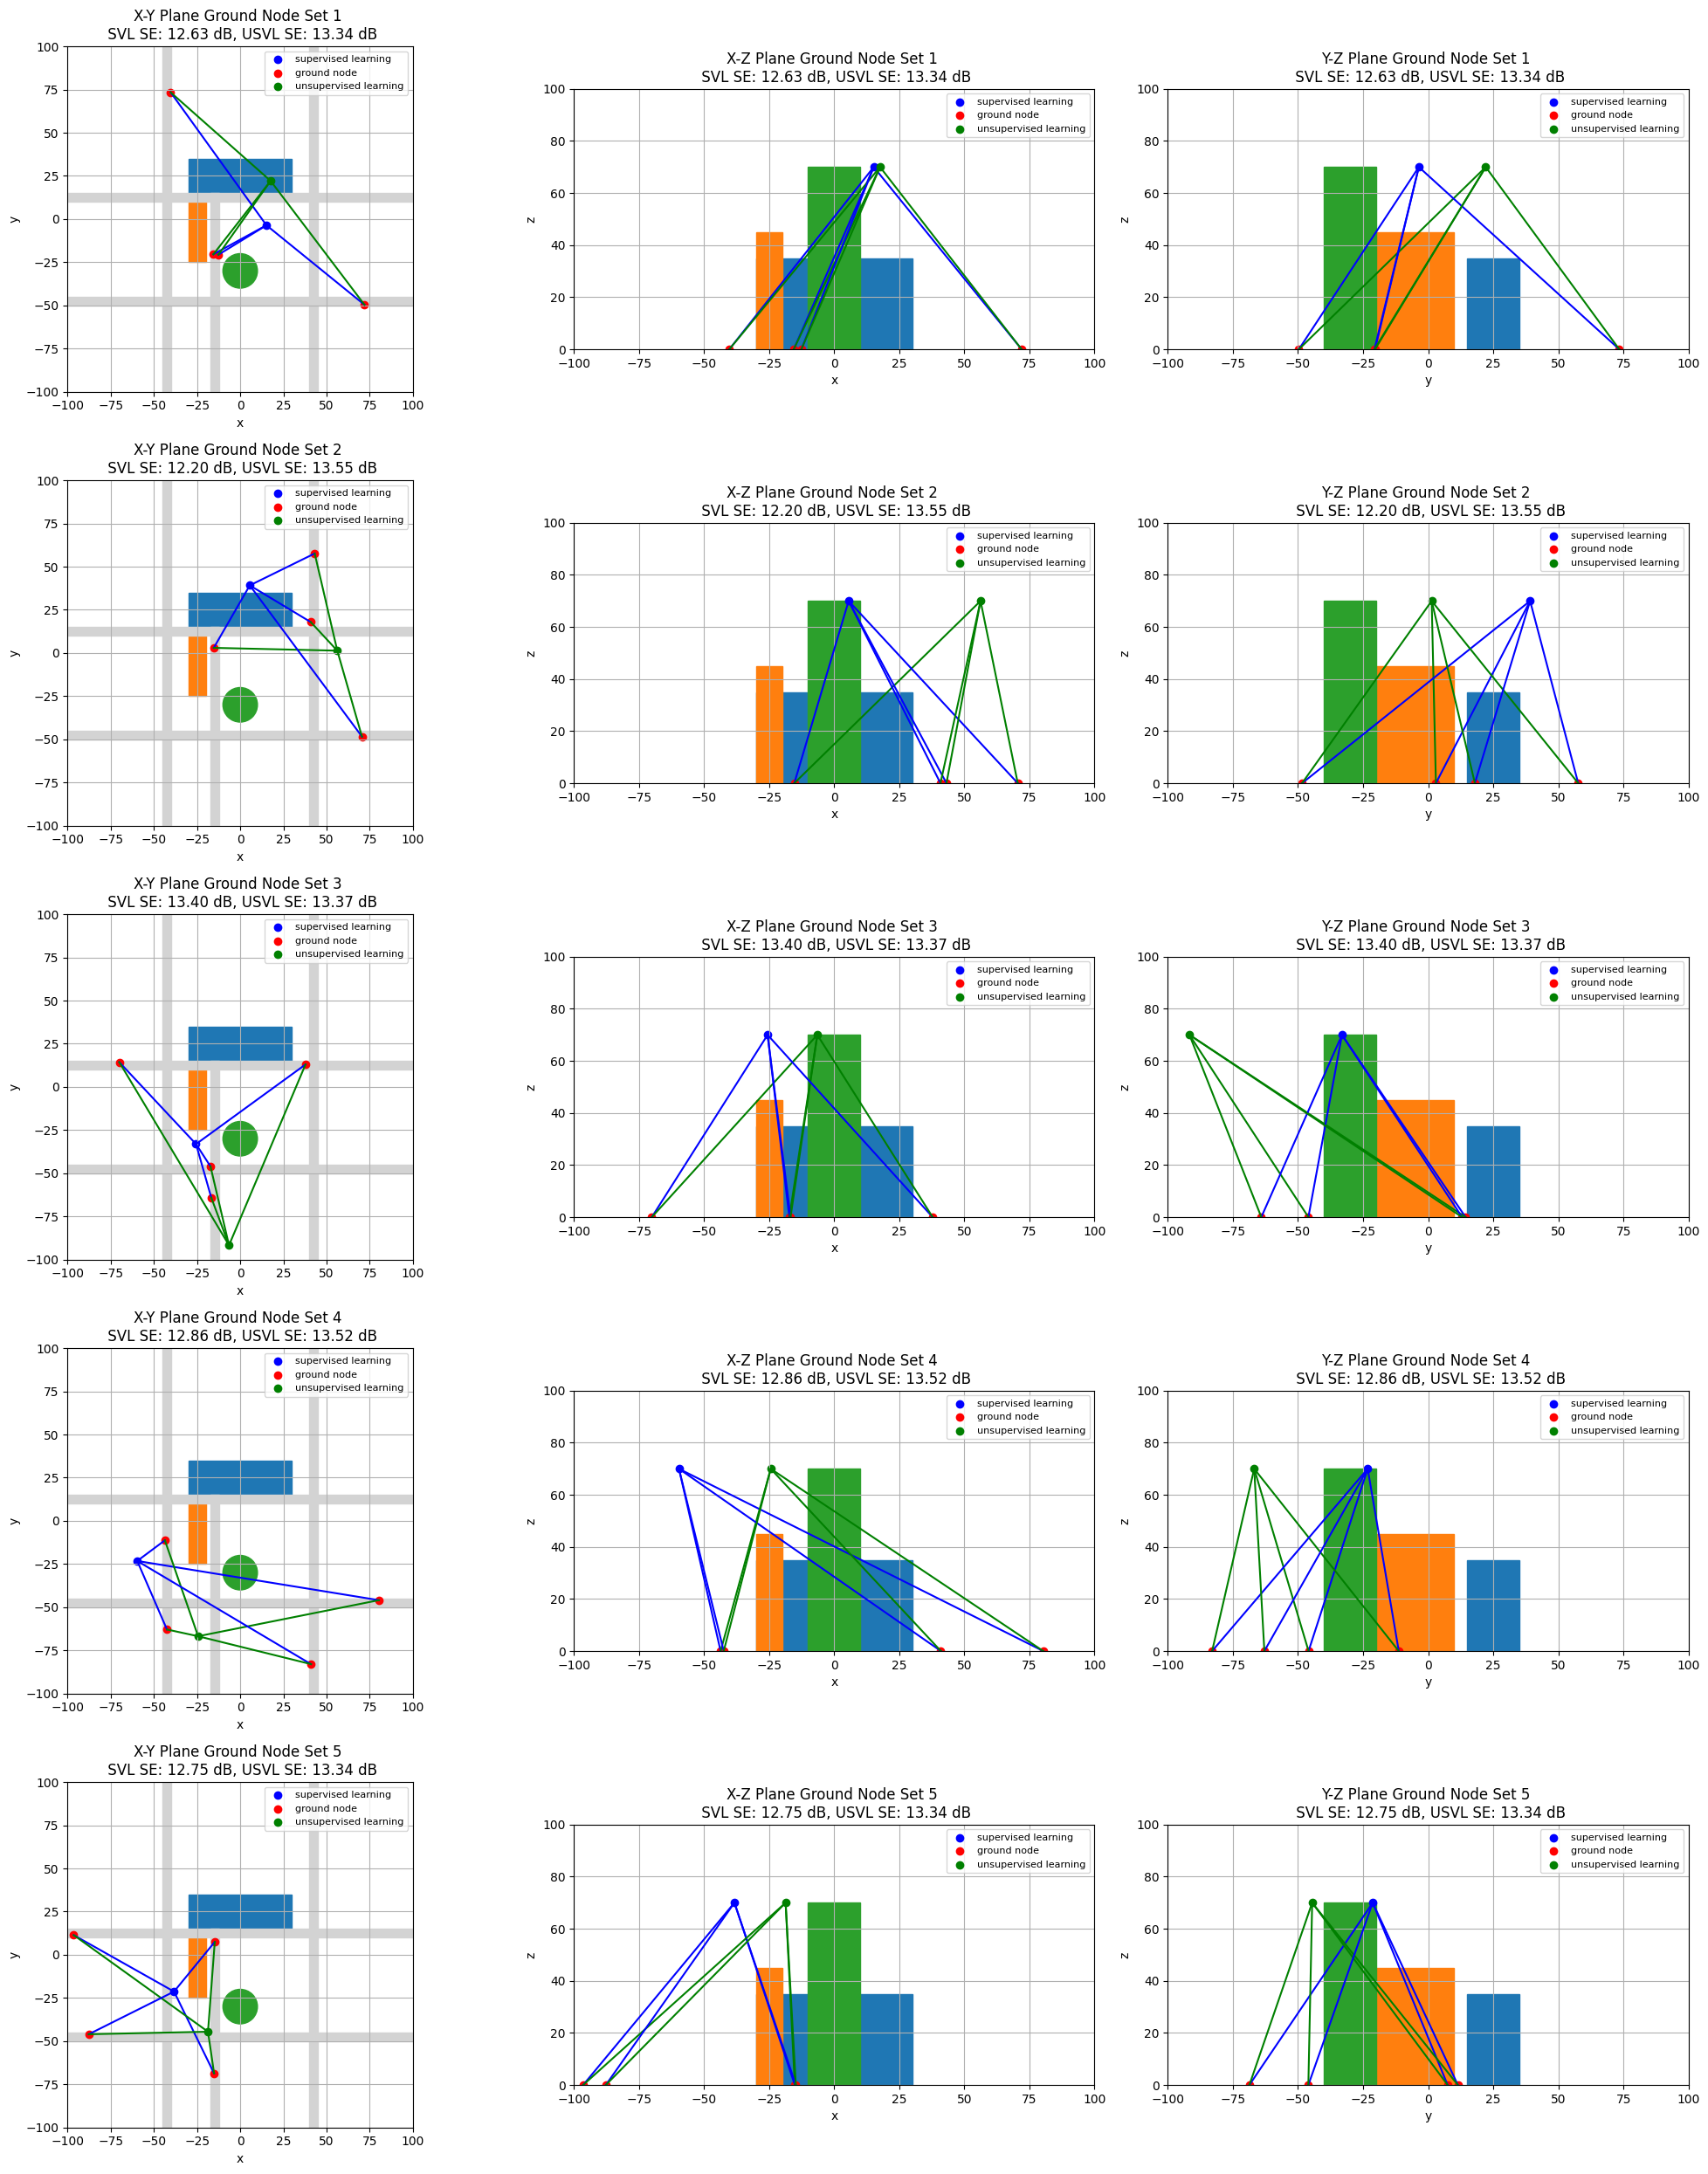

In [12]:
test1_x = torch.tensor(new_x_scaled[:5]).to(device, dtype=torch.float32)
fig, ax = plt.subplots(5, 3, figsize=(20, 25), constrained_layout=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
with torch.no_grad():
    for i in range(5):
        svl_checkpoint = torch.load(svl_model_path)
        usvl_checkpoint = torch.load(usvl_model_path)
        svl_model.load_state_dict(svl_checkpoint['model_state_dict'])
        usvl_model.load_state_dict(usvl_checkpoint['model_state_dict'])
            
        svl_model.eval()
        x_val_batch = test1_x[i].unsqueeze(0)
        svl_pred = svl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        svl_pred = torch.from_numpy(scaler_y.inverse_transform(svl_pred.cpu().numpy())).to(device, dtype=torch.float32)
        
        usvl_model.eval()
        usvl_pred = usvl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        usvl_pred = torch.hstack((usvl_pred, torch.ones(usvl_pred.shape[0], 1).to(device) * 0.85)) * 200 - 100

        x_val_origin = scaler_x.inverse_transform(x_val_batch.cpu())
                
        val_gnd = torch.from_numpy(x_val_origin).to(device, dtype=torch.float32).view(4, 3)
        val_station = torch.tensor(y_val[0], dtype=torch.float32).unsqueeze(0).to(device)
        svl_station = svl_pred.clone().detach().to(device, dtype=torch.float32)
        usvl_station = usvl_pred.clone().detach().to(device, dtype=torch.float32)
                
        val_se = calc_sig_strength_gpu(val_station, val_gnd, obst_points).cpu().numpy()
        svl_pred_se = calc_sig_strength_gpu(svl_station,  val_gnd, obst_points).cpu().numpy()
        usvl_pred_se = calc_sig_strength_gpu(usvl_station,  val_gnd, obst_points).cpu().numpy()
            
        val_gnd = val_gnd.cpu().numpy()
        svl_station = svl_station.cpu().numpy()
        usvl_station = usvl_station.cpu().numpy()
            
        ax[i, 0].grid(True)
        ax[i, 0].set_xlim(-100, 100)
        ax[i, 0].set_ylim(-100, 100)
        ax[i, 0].set_aspect('equal')
        ax[i, 0].add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
        ax[i, 0].add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
        ax[i, 0].add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
        ax[i, 0].add_patch(patches.Rectangle((-100, 10), 200, 5, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-45, -100), 5, 200, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((40, -100), 5, 200, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-100, -50), 200, 5, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-17, -100), 5, 115, fill=True, color='lightgray'))
        for j in range(4):
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 1], svl_station[0, 1]], color='b'))
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 1], usvl_station[0, 1]], color='g'))
        ax[i, 0].scatter(svl_station[0, 0], svl_station[0, 1], c='b', label='supervised learning')
        ax[i, 0].scatter(val_gnd[:, 0], val_gnd[:, 1], c='r', label='ground node')
        ax[i, 0].scatter(usvl_station[0, 0], usvl_station[0, 1], c='g', label='unsupervised learning')
        ax[i, 0].set_title(f"X-Y Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 0].set_xlabel('x')
        ax[i, 0].set_ylabel('y')
            
        ax[i, 0].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 1].grid(True)
        ax[i, 1].set_xlim(-100, 100)
        ax[i, 1].set_ylim(0, 100)
        ax[i, 1].set_aspect('equal')
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 60, 35, fill=True, color=colors[0]))
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 10, 45, fill=True, color=colors[1]))
        ax[i, 1].add_patch(patches.Rectangle((-10, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 1].scatter(svl_station[0, 0], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 1].scatter(val_gnd[:, 0], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 1].scatter(usvl_station[0, 0], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 1].set_title(f"X-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 1].set_xlabel('x')
        ax[i, 1].set_ylabel('z')
        ax[i, 1].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 2].grid(True)
        ax[i, 2].set_xlim(-100, 100)
        ax[i, 2].set_ylim(0, 100)
        ax[i, 2].set_aspect('equal')
        ax[i, 2].add_patch(patches.Rectangle((15, 0), 20, 35, fill=True, color=colors[0]))
        ax[i, 2].add_patch(patches.Rectangle((-25, 0), 35, 45, fill=True, color=colors[1]))
        ax[i, 2].add_patch(patches.Rectangle((-40, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], svl_station[0, 1]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], usvl_station[0, 1]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 2].scatter(svl_station[0, 1], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 2].scatter(val_gnd[:, 1], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 2].scatter(usvl_station[0, 1], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 2].set_title(f"Y-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 2].set_xlabel('y')
        ax[i, 2].set_ylabel('z')
        ax[i, 2].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
    plt.savefig("results/results2.png", dpi=300)
    plt.show()    

<Figure size 3000x3000 with 0 Axes>

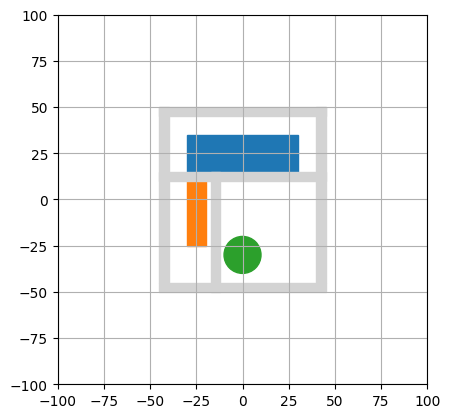

In [13]:
plt.figure(figsize=(30, 30))
fig, ax = plt.subplots()
ax.grid(True)
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)
ax.set_aspect('equal')

ax.add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
ax.add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
ax.add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
ax.add_patch(patches.Rectangle((-45, 10), 90, 5, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-45, -45), 5, 95, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((40, -45), 5, 95, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-45, -50), 90, 5, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-17, -50), 5, 65, fill=True, color='lightgray'))
ax.add_patch(patches.Rectangle((-45, 45), 90, 5, fill=True, color='lightgray'))

In [14]:
def is_onRoad(x, y):
    if -45 < x < 45 and 10 < y < 15:
        return True
    elif -45 < x < -40 and -45 < y < 50:
        return True
    elif 40 < x < 45 and -45 < y < 50:
        return True
    elif -45 < x < 45 and -50 < y < -45:
        return True
    elif -17 < x < -12 and -50 < y < 15:
        return True
    elif -45 < x < 45 and 45 < y < 50:
        return True
    
    else: return False

(-8.76993355669029, 13.6867897737297, 0)
(30.621665093079685, -49.341679492043575, 0)
(13.320290841315028, -46.92210181211092, 0)
(35.56330735924601, -45.99840536156703, 0)
0
(18.408386254367798, 14.450381158174679, 0)
(32.615640620020145, -47.33552465256987, 0)
(-44.47425874105362, 17.356869291633757, 0)
(43.37193623851874, -20.788059438541254, 0)
1
(-43.65397884921018, 17.28203323726534, 0)
(-15.892106663980314, 11.473758264783385, 0)
(-43.29623068356667, -24.014608819975905, 0)
(17.519927039277803, -45.435619515106595, 0)
2
(-13.919512098387756, 2.003370463650043, 0)
(44.83352732230864, -20.194935659379595, 0)
(41.314941254595794, -17.02862613328719, 0)
(-25.140763335816786, 49.75765150802661, 0)
3
(10.415655338394174, -45.66944647877082, 0)
(-13.543703763740282, 4.399254725996499, 0)
(17.93894460271015, 49.07961478945859, 0)
(42.75337368200326, 27.8373798450785, 0)
4


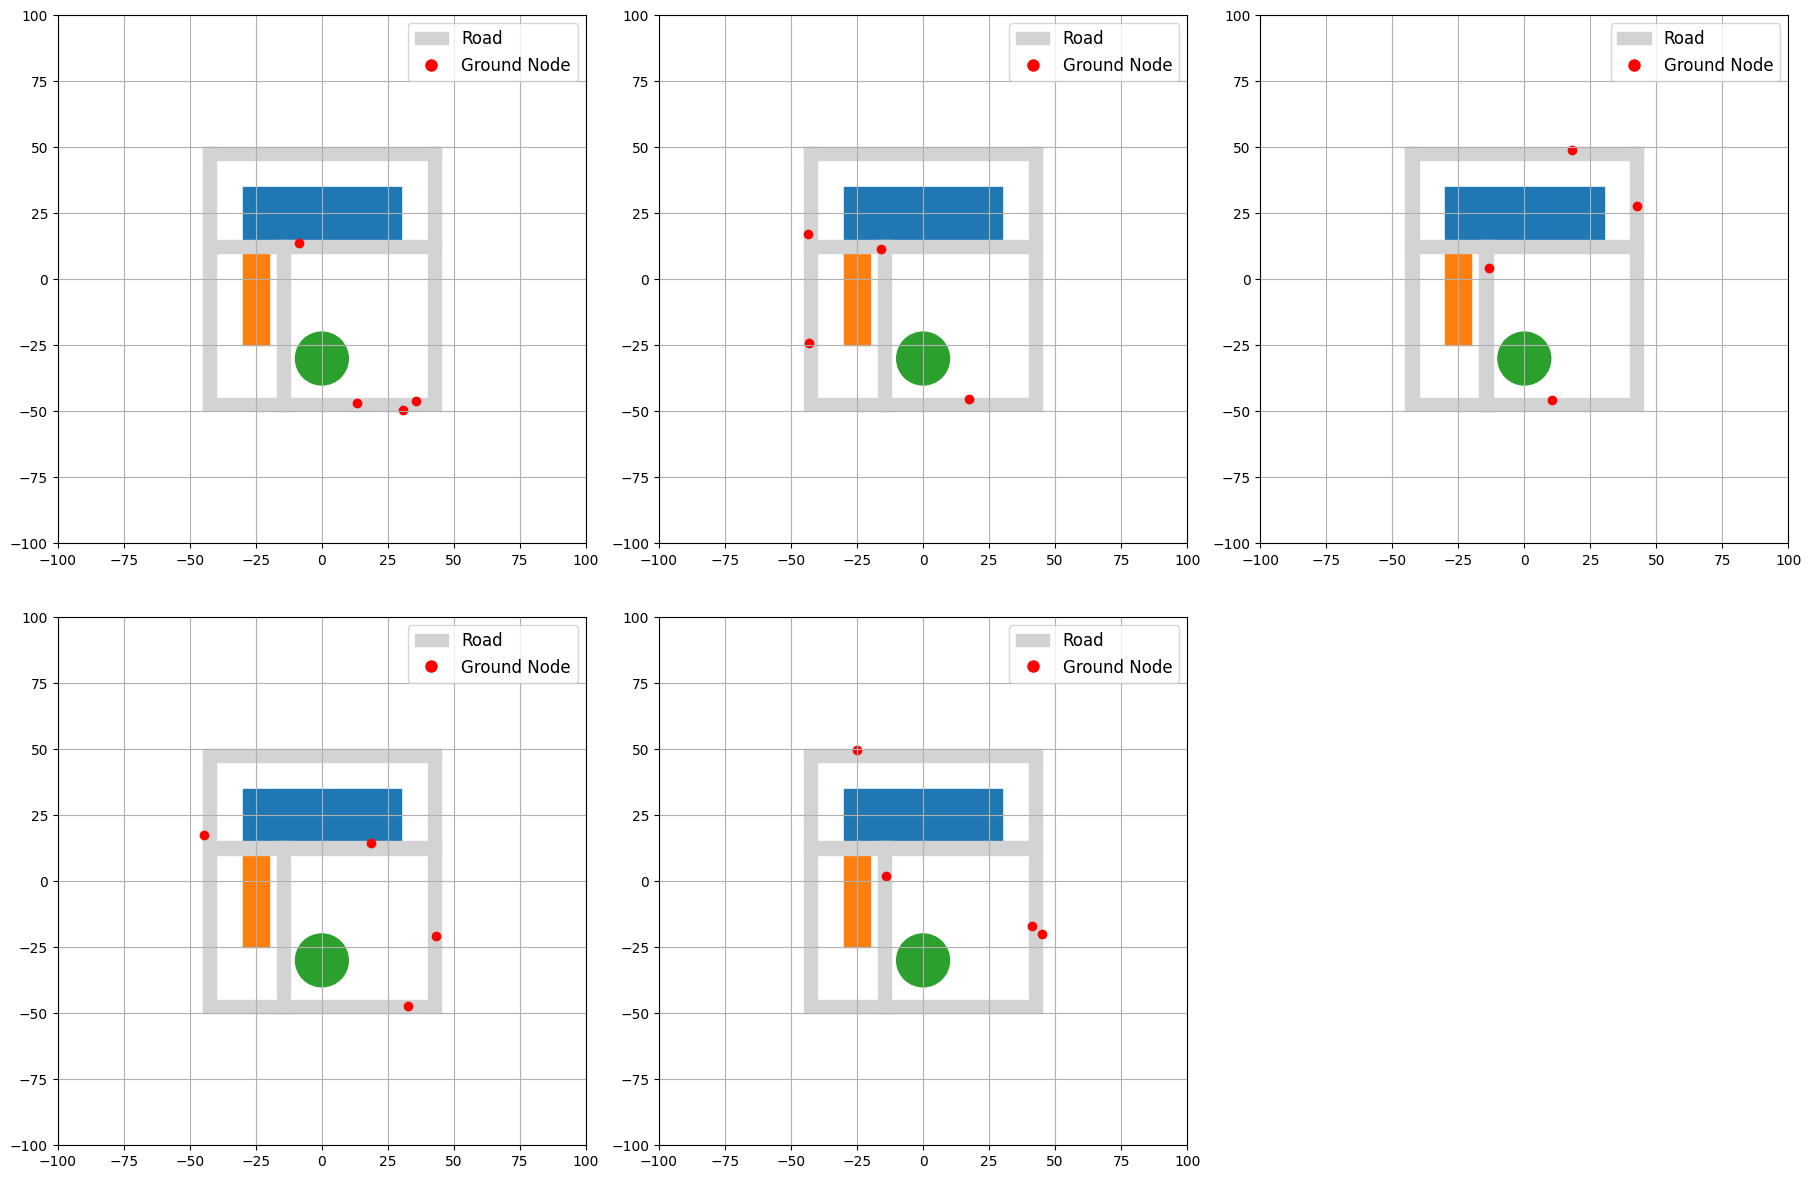

In [30]:
from matplotlib.patches import Patch
np.random.seed(0)

fig, ax = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)

gnd_nodes = np.zeros((5, 4, 3))
for i in range(5):
    row, col = i % 2, i // 2
    ax[row, col].grid(True)
    ax[row, col].set_xlim(-100, 100)
    ax[row, col].set_ylim(-100, 100)
    ax[row, col].set_aspect('equal')

    ax[row, col].add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
    ax[row, col].add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
    ax[row, col].add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
    ax[row, col].add_patch(patches.Rectangle((-45, 10), 90, 5, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-45, -45), 5, 95, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((40, -45), 5, 95, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-45, -50), 90, 5, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-17, -50), 5, 65, fill=True, color='lightgray'))
    ax[row, col].add_patch(patches.Rectangle((-45, 45), 90, 5, fill=True, color='lightgray'))
    gnd_node = []
    while len(gnd_node) < 4:
        x = np.random.rand() * 200 - 100
        y = np.random.rand() * 200 - 100
        z = 0
        if (x, y) not in gnd_node and is_onRoad(x, y):
            gnd_node.append((x, y, z))
            print((x, y, z))
            ax[row, col].scatter(x, y, c='r', label='Ground Node')
            
    lightgray_patch = Patch(color='lightgray', label='Road')
    scatter_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Ground Node')
    ax[row, col].legend(handles=[lightgray_patch, scatter_legend], loc='upper right', fontsize=12, ncol=1)

    gnd_nodes[i] = np.array(gnd_node)
    print(i)
fig.delaxes(ax[1, 2])

In [31]:
x = df.iloc[:, :12].values
y = df.iloc[:, 12:].values
gnd_nodes = gnd_nodes.reshape(-1, 12)

np.vstack([gnd_nodes, x])
new_scaler_x = MinMaxScaler(feature_range=(0, 1))
new_x_scaled = new_scaler_x.fit_transform(np.vstack([gnd_nodes, x]))
([new_x_scaled[5:]] == x_scaled[:]).all()

np.True_

/tmp/ipykernel_228591/3490802984.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  svl_checkpoint = torch.load(svl_model_path)
/tmp/ipykernel_228591/3490802984.py:8: Futur

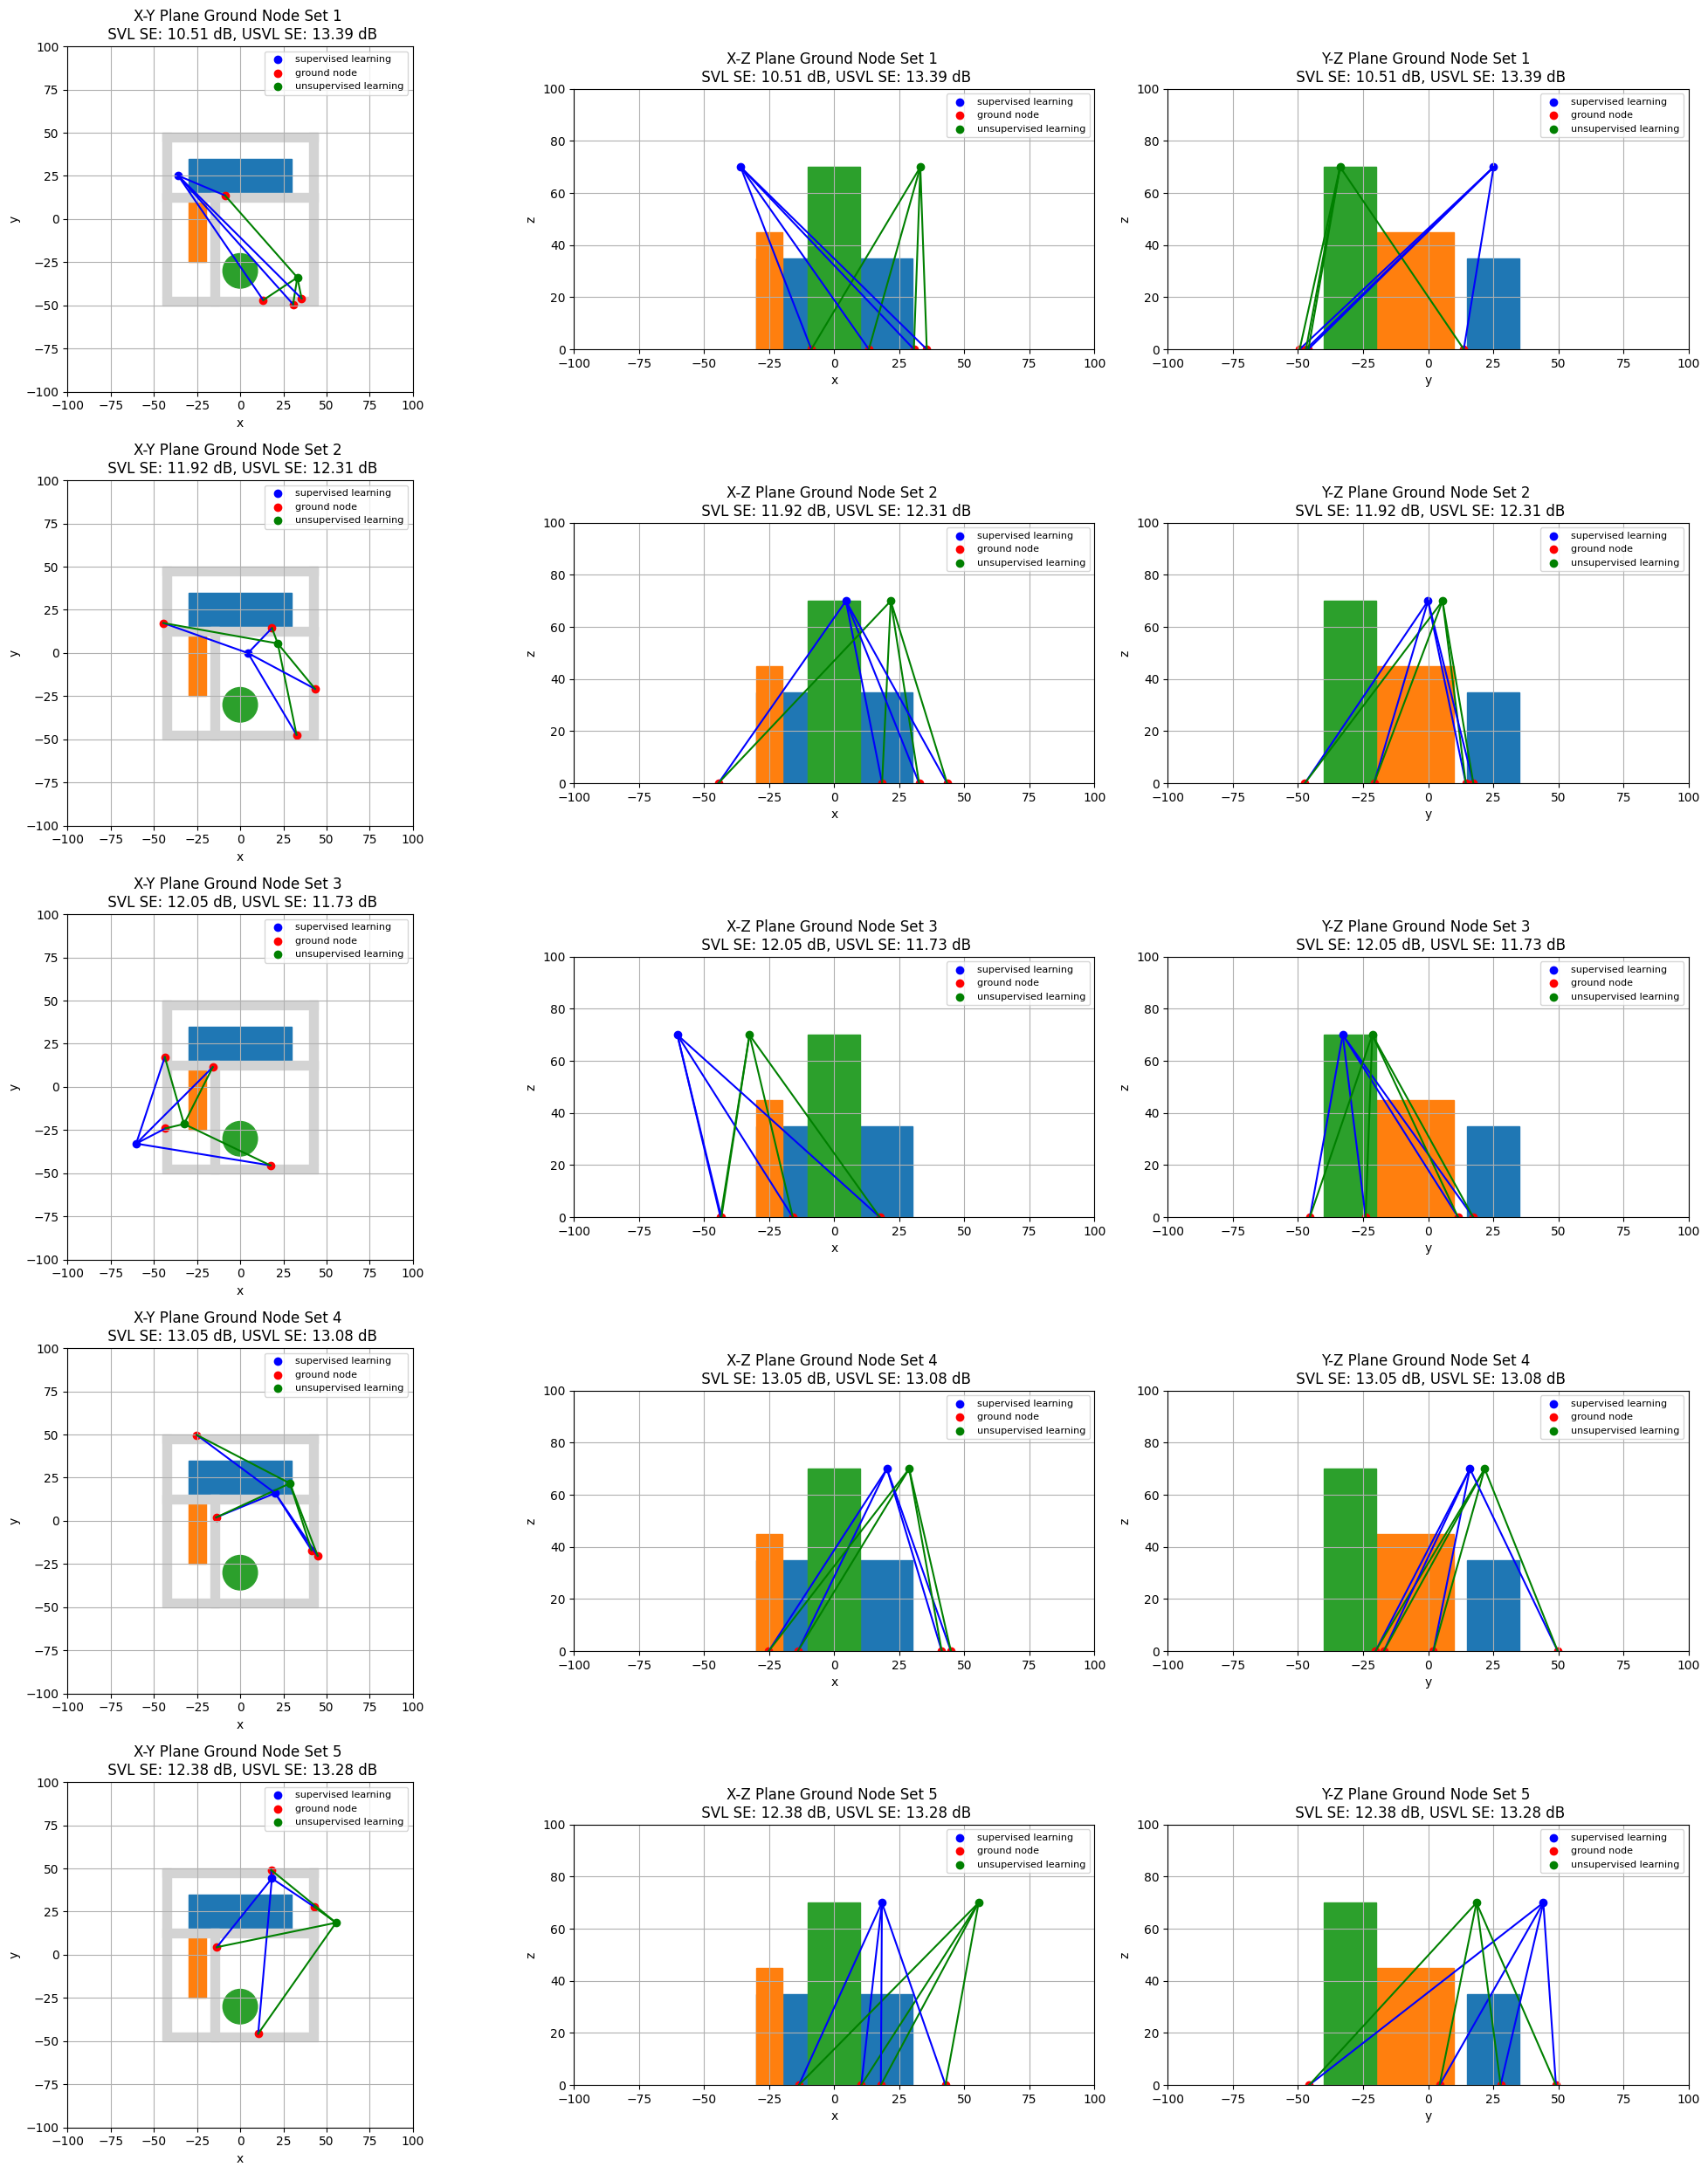

In [32]:
test1_x = torch.tensor(new_x_scaled[:5]).to(device, dtype=torch.float32)
fig, ax = plt.subplots(5, 3, figsize=(20, 25), constrained_layout=True)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
with torch.no_grad():
    for i in range(5):
        svl_checkpoint = torch.load(svl_model_path)
        usvl_checkpoint = torch.load(usvl_model_path)
        svl_model.load_state_dict(svl_checkpoint['model_state_dict'])
        usvl_model.load_state_dict(usvl_checkpoint['model_state_dict'])
            
        svl_model.eval()
        x_val_batch = test1_x[i].unsqueeze(0)
        svl_pred = svl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        svl_pred = torch.from_numpy(scaler_y.inverse_transform(svl_pred.cpu().numpy())).to(device, dtype=torch.float32)
        
        usvl_model.eval()
        usvl_pred = usvl_model(x_val_batch)
        x_val_batch_reshaped = torch.from_numpy(scaler_x.inverse_transform(x_val_batch.cpu().numpy())).to(device, dtype=torch.float32).view(-1, 4, 3)
        usvl_pred = torch.hstack((usvl_pred, torch.ones(usvl_pred.shape[0], 1).to(device) * 0.85)) * 200 - 100

        x_val_origin = scaler_x.inverse_transform(x_val_batch.cpu())
                
        val_gnd = torch.from_numpy(x_val_origin).to(device, dtype=torch.float32).view(4, 3)
        val_station = torch.tensor(y_val[0], dtype=torch.float32).unsqueeze(0).to(device)
        svl_station = svl_pred.clone().detach().to(device, dtype=torch.float32)
        usvl_station = usvl_pred.clone().detach().to(device, dtype=torch.float32)
                
        val_se = calc_sig_strength_gpu(val_station, val_gnd, obst_points).cpu().numpy()
        svl_pred_se = calc_sig_strength_gpu(svl_station,  val_gnd, obst_points).cpu().numpy()
        usvl_pred_se = calc_sig_strength_gpu(usvl_station,  val_gnd, obst_points).cpu().numpy()
            
        val_gnd = val_gnd.cpu().numpy()
        svl_station = svl_station.cpu().numpy()
        usvl_station = usvl_station.cpu().numpy()
            
        ax[i, 0].grid(True)
        ax[i, 0].set_xlim(-100, 100)
        ax[i, 0].set_ylim(-100, 100)
        ax[i, 0].set_aspect('equal')
        ax[i, 0].add_patch(patches.Rectangle((-30, 15), 60, 20, fill=True, color=colors[0]))
        ax[i, 0].add_patch(patches.Rectangle((-30, -25), 10, 35, fill=True, color=colors[1]))
        ax[i, 0].add_patch(patches.Circle((0, -30), 10, fill=True, color=colors[2]))
        ax[i, 0].add_patch(patches.Rectangle((-45, 10), 90, 5, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-45, -45), 5, 95, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((40, -45), 5, 95, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-45, -50), 90, 5, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-17, -50), 5, 65, fill=True, color='lightgray'))
        ax[i, 0].add_patch(patches.Rectangle((-45, 45), 90, 5, fill=True, color='lightgray'))
        for j in range(4):
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 1], svl_station[0, 1]], color='b'))
            ax[i, 0].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 1], usvl_station[0, 1]], color='g'))
        ax[i, 0].scatter(svl_station[0, 0], svl_station[0, 1], c='b', label='supervised learning')
        ax[i, 0].scatter(val_gnd[:, 0], val_gnd[:, 1], c='r', label='ground node')
        ax[i, 0].scatter(usvl_station[0, 0], usvl_station[0, 1], c='g', label='unsupervised learning')
        ax[i, 0].set_title(f"X-Y Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 0].set_xlabel('x')
        ax[i, 0].set_ylabel('y')
            
        ax[i, 0].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 1].grid(True)
        ax[i, 1].set_xlim(-100, 100)
        ax[i, 1].set_ylim(0, 100)
        ax[i, 1].set_aspect('equal')
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 60, 35, fill=True, color=colors[0]))
        ax[i, 1].add_patch(patches.Rectangle((-30, 0), 10, 45, fill=True, color=colors[1]))
        ax[i, 1].add_patch(patches.Rectangle((-10, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], svl_station[0, 0]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 1].add_line(plt.Line2D([val_gnd[j, 0], usvl_station[0, 0]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 1].scatter(svl_station[0, 0], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 1].scatter(val_gnd[:, 0], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 1].scatter(usvl_station[0, 0], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 1].set_title(f"X-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 1].set_xlabel('x')
        ax[i, 1].set_ylabel('z')
        ax[i, 1].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
        ax[i, 2].grid(True)
        ax[i, 2].set_xlim(-100, 100)
        ax[i, 2].set_ylim(0, 100)
        ax[i, 2].set_aspect('equal')
        ax[i, 2].add_patch(patches.Rectangle((15, 0), 20, 35, fill=True, color=colors[0]))
        ax[i, 2].add_patch(patches.Rectangle((-25, 0), 35, 45, fill=True, color=colors[1]))
        ax[i, 2].add_patch(patches.Rectangle((-40, 0), 20, 70, fill=True, color=colors[2]))
        for j in range(4):
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], svl_station[0, 1]], [val_gnd[j, 2], svl_station[0, 2]], color='b'))
            ax[i, 2].add_line(plt.Line2D([val_gnd[j, 1], usvl_station[0, 1]], [val_gnd[j, 2], usvl_station[0, 2]], color='g'))
        ax[i, 2].scatter(svl_station[0, 1], svl_station[0, 2], c='b', label='supervised learning')
        ax[i, 2].scatter(val_gnd[:, 1], val_gnd[:, 2], c='r', label='ground node')
        ax[i, 2].scatter(usvl_station[0, 1], usvl_station[0, 2], c='g', label='unsupervised learning')
        ax[i, 2].set_title(f"Y-Z Plane Ground Node Set {i + 1} \n SVL SE: {svl_pred_se[0]:.2f} dB, USVL SE: {usvl_pred_se[0]:.2f} dB")
        ax[i, 2].set_xlabel('y')
        ax[i, 2].set_ylabel('z')
        ax[i, 2].legend(loc='upper right', fontsize=8)
        fig.tight_layout()
            
    plt.savefig("results/results3.png", dpi=300)
    plt.show()    